# NeuroGraphNet

*A graph-based deep learning framework for EEG seizure detection, designed to improve accuracy and interpretability by leveraging Graph Neural Networks (GNNs) to capture spatial and temporal brain dynamics.*

<hr />

This notebook presents **NeuroGraphNet**, a model that applies Graph Neural Networks to EEG data for seizure detection. The primary goal is to **compare the performance and interpretability of graph-based methods versus traditional deep learning approaches**. Through this comparison, we aim to demonstrate the advantages of incorporating brain connectivity information into the learning process.

**Authors**: Luca Di Bello, Guillaume André Bélissent, Abdessalem Ben Ali, Beatriz Izquierdo González

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader
import time
import os

from seiz_eeg.dataset import EEGDataset
from util.seeder import seed_everything

# create useful constants
RANDOM_SEED = 42
DATA_ROOT = Path("/home/ogut/data")
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset preprocessing

We apply a frequency-domain transformation to each EEG segment using the fft_filtering function. This function performs [band-pass filtering](https://en.wikipedia.org/wiki/Band-pass_filter) via the Fast Fourier Transform (FFT), isolating signal components within a specific frequency range—typically between 0.5 Hz and 30 Hz, which is commonly used in seizure detection research.

This process helps suppress noise and eliminate irrelevant frequency components, allowing the models to focus on the most informative parts of the signal. The filtered EEG segments are then loaded into memory as NumPy arrays using the `EEGDataset` class with optional prefetching enabled to speed up data access during training.

Also, we split the `label` attribute into a pandas [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html) in order to easily query data. The original `label` index follows this format:

```plaintext
<patient_id>_<session_no>_<clip_no>_<segment_no>
```


  

In [2]:
from util.filter import fft_filtering

start = time.time()
print("⏳ Loading EEG segment tables…")
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet").dropna()
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet").dropna()
print(f"✔️ Loaded: {len(clips_tr)} train rows, {len(clips_te)} test rows "
      f"(took {time.time()-start:.1f}s)")

# ——— build datasets ———
print("⏳ Building EEGDataset objects…")
ds_start = time.time()
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)
print(f"✔️ Train dataset ready: {len(dataset_tr)} segments (took {time.time()-ds_start:.1f}s)")
dataset_te = EEGDataset(
    clips_te,
    signals_root=DATA_ROOT / "test",
    signal_transform=fft_filtering,
    prefetch=True,
    return_id=True,
)
print(f"✔️ Test dataset ready: {len(dataset_te)} segments (took {time.time()-ds_start:.1f}s)")

# ——— create data loaders ———
print("⏳ Creating DataLoaders…")
dl_start = time.time()
common_loader_kwargs = dict(
    batch_size=2048,
    num_workers=16,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=8,
)

⏳ Loading EEG segment tables…
✔️ Loaded: 12993 train rows, 3614 test rows (took 0.2s)
⏳ Building EEGDataset objects…
✔️ Train dataset ready: 12993 segments (took 21.6s)
✔️ Test dataset ready: 3614 segments (took 28.1s)
⏳ Creating DataLoaders…


## Dataset structure

In this section the general dataset structure will be analyzed in order to (1) provide the reader some useful insights about the data we are working with (2) find some characteristics that allow us to distinguish between seizure and non-seizure people

Useful resources: 
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/clips.html>
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/dataset.html#seiz_eeg.dataset.EEGDataset>
- <https://seizure-eeg.readthedocs.io/en/latest/tutorials/1-events_and_dataframes.html> <-- most important

#### General information

In [3]:
clips_tr.columns

Index(['label', 'start_time', 'end_time', 'date', 'sampling_rate',
       'signals_path'],
      dtype='object')

In [4]:
print(f"- Clip length: {dataset_tr.clip_lenght} [s]")
print(f"- Sampling rate: {dataset_tr.s_rate} [Hz]")

print("\n[Dataset stats]")

# Calculate total patients
total_rows = clips_tr.shape[0]
total_patients = clips_tr.index.get_level_values("patient").nunique()
total_sessions = clips_tr.index.get_level_values("segment").nunique()
total_segments = clips_tr.index.get_level_values("segment").nunique()

print(f"- Total rows: {total_rows}")
print(f"- Total patients: {total_patients}")
print(f"- Total sessions: {total_sessions}")
print(f"- Total segments: {total_segments}")

# Calculate average sessions per patient
# Group by patient, count unique sessions within each patient, then average
avg_sessions_per_patient = clips_tr.groupby(level='patient').apply(lambda x: x.index.get_level_values('segment').nunique()).mean()

# Calculate average segments per session
# Group by unique session (patient, segment), count segments (rows) in each group, then average
avg_segments_per_session = clips_tr.groupby(level=['patient', 'segment']).size().mean()

# Calculate average segments per patient
# Group by patient, count segments (rows) for each patient, then average
avg_segments_per_patient = clips_tr.groupby(level="patient").size().mean()

print(f"- Avg. segments per session: {avg_segments_per_session}")
print(f"- Avg. segments per patient: {avg_segments_per_patient}")

print("\n[Sensor information]")
channel_names = dataset_tr.get_channels_names()
print(f"- Total channels: {len(channel_names)}")
print(f"- Channel names: {channel_names}")

- Clip length: 12.0 [s]
- Sampling rate: 250 [Hz]

[Dataset stats]
- Total rows: 12993
- Total patients: 97
- Total sessions: 285
- Total segments: 285
- Avg. segments per session: 1.3979987088444157
- Avg. segments per patient: 133.94845360824743

[Sensor information]
- Total channels: 19
- Channel names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


In [5]:
# Set useful variables
clip_length = dataset_tr.clip_lenght # 12 seconds
sampling_rate = dataset_tr.s_rate # 250 Hz
time_points = clip_length * sampling_rate # 12 s * 250 Hz = 3000 time points
num_channels = len(channel_names) # 19 channels (1 channel = 1 sensor)

**Sensor placement map**:

<img src="./assets/sensor_map.png" style="max-height: 500px;" />

## Exploratory data analysis

NOTE: the exploratory data analysis is performed only on training segments! 

### Label distribution

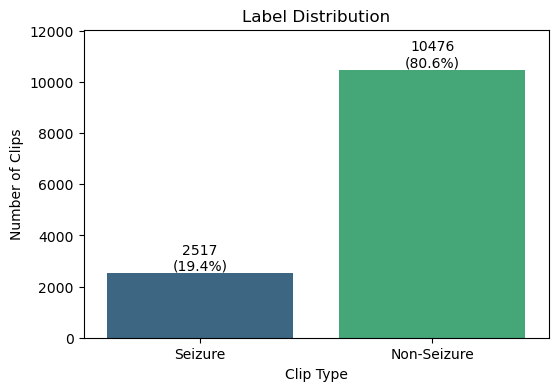

In [6]:
# Create a DataFrame for the label distribution plot
label_df = pd.DataFrame({'label': dataset_tr.get_label_array()})
label_df['Clip Type'] = label_df['label'].map({0: 'Non-Seizure', 1: 'Seizure'})

# Plot the label distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=label_df, x='Clip Type', palette='viridis', hue='Clip Type', dodge=False)
plt.title('Label Distribution')
plt.xlabel('Clip Type')
plt.ylabel('Number of Clips')

# Add counts and percentages on top of bars
total_count = len(label_df)
for container in ax.containers:
    labels = [f'{int(v)}\n({(100 * v / total_count):.1f}%)' for v in container.datavalues]
    ax.bar_label(container, labels=labels)

plt.ylim(0, label_df['Clip Type'].value_counts().max() * 1.15) # Adjust y-limit for text
plt.show()

### Seizure vs Non-Seizure Clips: per-channel signal overview

Plotting Example Non-Seizure Clip with shape: (354, 19)


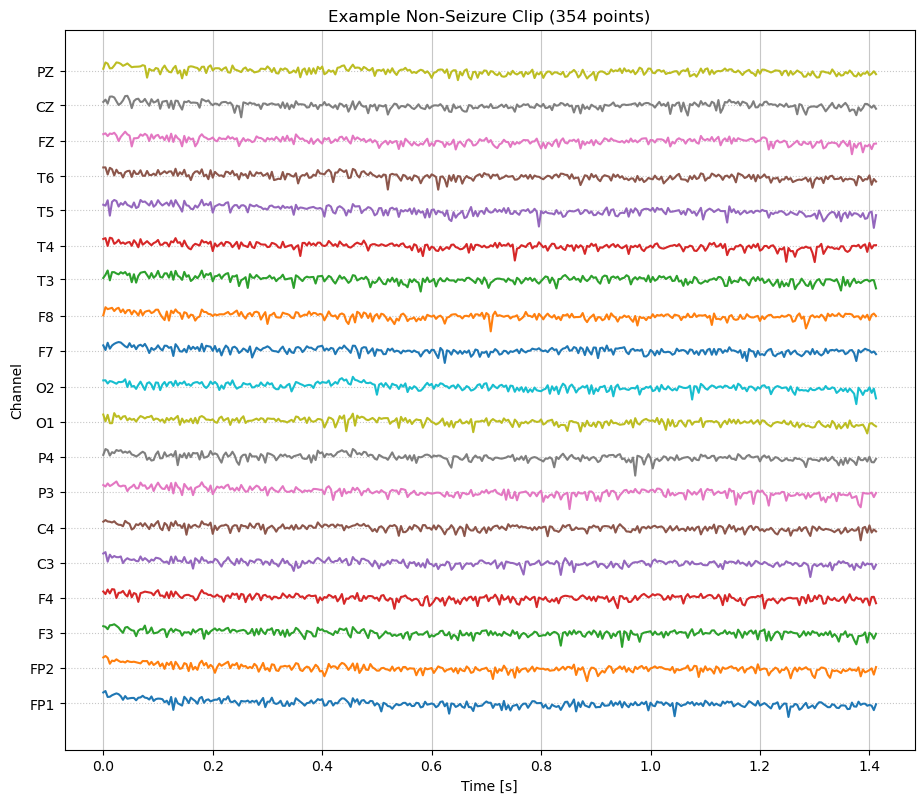

Plotting Example Seizure Clip with shape: (354, 19)


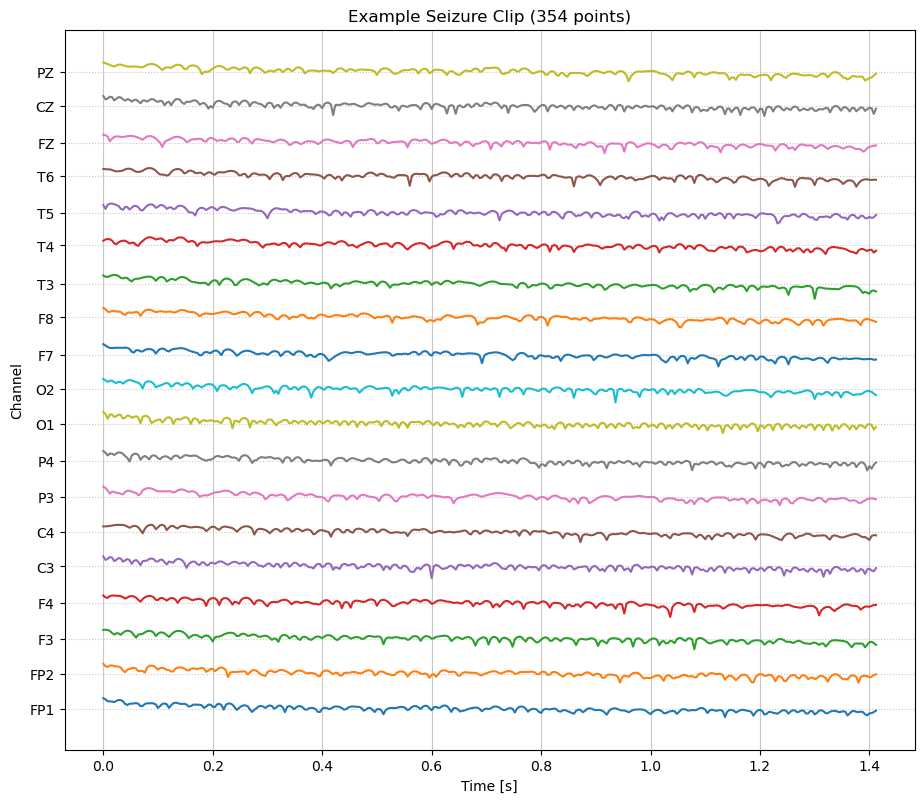

In [7]:
from util.plot import plot_eeg_clip

seizure_example = None
non_seizure_example = None

try:
    for x, y in dataset_tr:
        if isinstance(x, np.ndarray) and x.ndim == 2:
            if y == 1 and seizure_example is None:
                seizure_example = x
            elif y == 0 and non_seizure_example is None:
                non_seizure_example = x
        # Stop if both examples are found
        if seizure_example is not None and non_seizure_example is not None:
            break
except TypeError as e:
    print(f"Error iterating through dataset: {e}")
    print("Please ensure 'dataset_tr' yields tuples of (signal_array, label).")
    seizure_example = None
    non_seizure_example = None


# Plot each example
if non_seizure_example is not None:
    plot_eeg_clip(non_seizure_example, "Example Non-Seizure Clip", sampling_rate, channel_names, offset_factor=10)
else:
    print("Could not find a non-seizure example clip to plot.")

if seizure_example is not None:
    plot_eeg_clip(seizure_example, "Example Seizure Clip", sampling_rate, channel_names, offset_factor=10)
else:
    print("Could not find a seizure example clip to plot.")


### Seizure vs Non-Seizure Clips: Power Spectral Density

The [*Power Spectral Density* (PSD)](https://en.wikipedia.org/wiki/Spectral_density) describes how the power of a signal (like EEG, often treated as a stationary random process over short intervals) is distributed across different frequencies. It's suitable for ongoing signals where total energy might be infinite, but average power is finite.

The *Power Spectral Density*, $S_{xx}(f)$, is fundamentally related to the signal's autocorrelation function, $R_{xx}(\tau)$, via the [Wiener-Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem), which states that the PSD is the Fourier transform ($\mathcal{F}$) of the autocorrelation function:

$$
S_{xx}(f) = \mathcal{F}\{\mathbf{R}_{xx}(\tau)\}
$$

In practice, the PSD function $S_{xx}(f)$ can be estimated from finite signal segments using techniques like [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method), which averages modified periodograms from overlapping windowed portions of the signal.

Suggested resources:

- <https://ethz.ch/content/dam/ethz/special-interest/baug/ibk/structural-mechanics-dam/education/identmeth/2020/welch.pdf>
- <https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html>

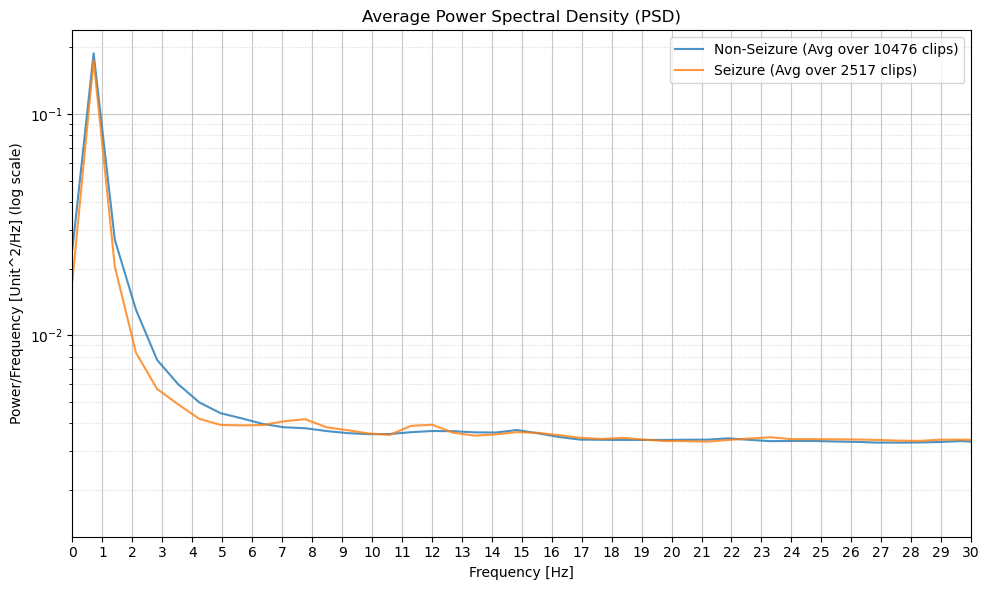

PSD calculation complete for 2517 seizure and 10476 non-seizure clips (out of 12993 processed).


In [8]:
from scipy.signal import welch

# local variables to store partial results
psd_seizure = []
psd_non_seizure = []
count_seizure = 0
count_non_seizure = 0

# NOTE: limit for number of clips to process.
# Increasing this, means more precision, but also more memory + computation time
limit = 10e4 # default limit: 100k clips
processed_count = 0

# cycle through dataset
freqs = None 
for x, y in dataset_tr:
    # check if we reached the limit of clips to process
    if processed_count >= limit:
        print(f"Reached calculation limit of {limit} clips for PSD.")
        break
    processed_count += 1

    # Ensure that clip is well-formed
    if not isinstance(x, np.ndarray) or x.ndim != 2 or x.shape[0] < 2: # Need at least 2 points for welch
            print(f"Warning: Skipping clip {processed_count} due to invalid data shape {x.shape if isinstance(x, np.ndarray) else type(x)}")
            continue

    # unpack current clip data
    actual_time_points, actual_num_channels = x.shape

    # --- Calculate PSD using Welch's method ---
    # Use nperseg=sampling_rate = 1-second windows (250Hz => 250 points)
    # Since each segment is 12 seconds, we can use directly the entire clip!
    # NOTE: in order to avoid problem if we miss some data, we can use the minimum between the clip length and the actual time points
    nperseg_val = min(sampling_rate * clip_length, actual_time_points)
    if nperseg_val < 2: # Welch requires nperseg >= 2
            print(f"Warning: Skipping clip {processed_count} due to insufficient length ({actual_time_points}) for PSD calculation.")
            continue
    try:
        # Calculate PSD for each channel (axis=0)
        f, psd_chans = welch(x, fs=sampling_rate, axis=0, nperseg=nperseg_val)
        if freqs is None: # Store frequencies from the first successful calculation
            freqs = f

        # Average PSD across channels for this clip
        psd_clip_avg = psd_chans.mean(axis=1)

        # store the PSD for the current clip in the appropriate list
        if y == 1:
            psd_seizure.append(psd_clip_avg)
            count_seizure += 1
        else:
            psd_non_seizure.append(psd_clip_avg)
            count_non_seizure += 1
    except ValueError as e:
            # skip if calculation gives an error
            print(f"Warning: Error calculating PSD for clip {processed_count}: {e}")
            continue

# --- Compute average PSD for each class (seizure / non-seizure) ---
avg_psd_seizure = np.mean(psd_seizure, axis=0) if count_seizure > 0 else None
avg_psd_non_seizure = np.mean(psd_non_seizure, axis=0) if count_non_seizure > 0 else None

# --- Plotting PSD ---
if freqs is not None:
    plt.figure(figsize=(10, 6))
    plot_successful = False
    if avg_psd_non_seizure is not None:
        # Ensure avg_psd has same length as freqs
        if len(avg_psd_non_seizure) == len(freqs):
             plt.semilogy(freqs, avg_psd_non_seizure, label=f'Non-Seizure (Avg over {count_non_seizure} clips)', alpha=0.8)
             plot_successful = True
        else:
             print(f"Warning: Mismatch between freqs ({len(freqs)}) and non-seizure PSD ({len(avg_psd_non_seizure)}) lengths.")

    if avg_psd_seizure is not None:
        # Ensure avg_psd has same length as freqs
        if len(avg_psd_seizure) == len(freqs):
            plt.semilogy(freqs, avg_psd_seizure, label=f'Seizure (Avg over {count_seizure} clips)', alpha=0.8)
            plot_successful = True
        else:
             print(f"Warning: Mismatch between freqs ({len(freqs)}) and seizure PSD ({len(avg_psd_seizure)}) lengths.")

    if plot_successful:
        plt.title('Average Power Spectral Density (PSD)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Power/Frequency [Unit^2/Hz] (log scale)')
        plt.xlim(0.5, 30) # Limit to only the first 30 Hz (the other frequencies have been filtered out!)
        plt.xticks(np.arange(0, 31, 1))
        plt.legend()  # check if we reached the limit of clips to process
        # Customize grid from seaborn theme if needed
        plt.grid(True, which='major', axis='y', linestyle='-', alpha=0.7)
        plt.grid(True, which='minor', axis='y', linestyle=':', alpha=0.5)
        plt.grid(True, axis='x', linestyle='-', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No PSD data was successfully prepared for plotting.")
elif processed_count > 0:
     print("Could not determine frequencies from the processed clips.")
else:
     print("No clips were processed for PSD.")


# Final status summary
if count_seizure == 0 and count_non_seizure == 0:
    print("No clips successfully processed for PSD.")
elif count_seizure == 0:
    print(f"Processed {count_non_seizure} non-seizure clips for PSD, but no seizure clips found/processed.")
elif count_non_seizure == 0:
    print(f"Processed {count_seizure} seizure clips for PSD, but no non-seizure clips found/processed.")
else:
    print(f"PSD calculation complete for {count_seizure} seizure and {count_non_seizure} non-seizure clips (out of {processed_count} processed).")


From the plot above is possible to see that the PSD shapes are similar, with power decreasing as frequency increases. However, there's a clear distinction in the $1−7$ Hz range (delta and theta bands), where the non-seizure class shows significantly higher average power compared to the seizure class. Above approximately $7$ Hz, the power levels for both classes become nearly identical. 

This indicates that increased low-frequency power is the primary differentiator observed in this PSD analysis.

### Seizure vs Non-Seizure Clips: Channel-wise variance

In the previous plot we examined the overall signal power overtime, and identified an important feature to distinguish between the two classes.

In this new analysis we focus on the channel-wise signal variance across seizure - non-seizure clips. This allows us to understand whether certain sensors give interesting results.

Plotting channel variance distributions...


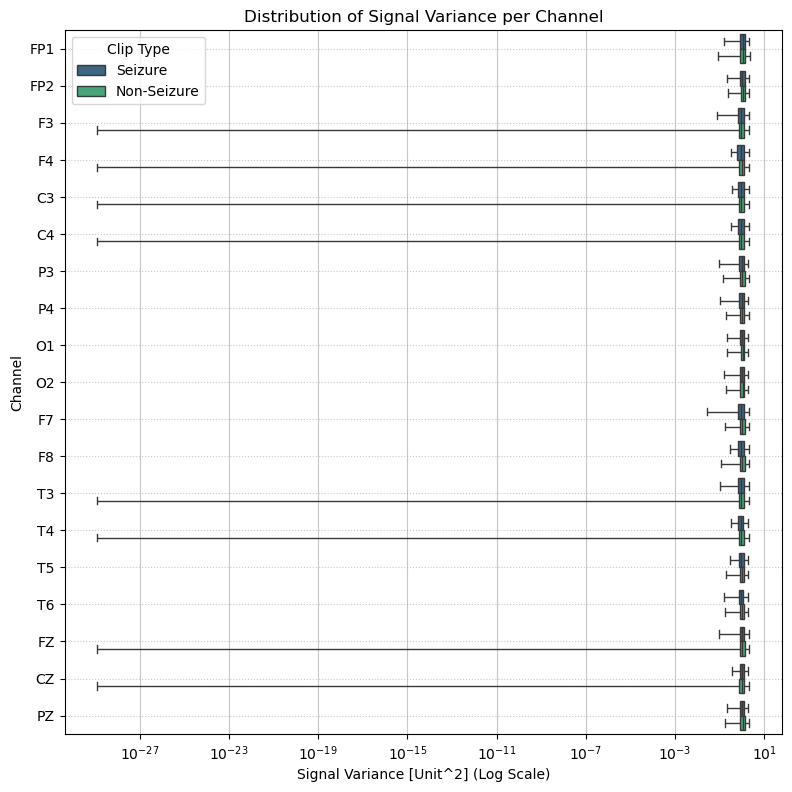

In [9]:
channel_variances = []
limit = 10e4 # default limit: 100k clips

# Iterate through dataset to calculate variance for each channel in each clip
processed_count = 0
for x, y in dataset_tr:
     if processed_count >= limit:
         print(f"Reached calculation limit of {limit} clips for variance.")
         break
     processed_count += 1

     if isinstance(x, np.ndarray) and x.ndim == 2:
         # Calculate variance along the time axis (axis=0) for each channel
         variances = np.var(x, axis=0)
         # Store variance along with label and channel index/name
         for i, var_val in enumerate(variances):
              channel_variances.append({
                  'variance': var_val,
                  'label': y,
                  'channel_index': i,
                  'channel_name': channel_names[i] if i < len(channel_names) else f'Ch {i}'
              })

# Create DataFrame for plotting
variance_df = pd.DataFrame(channel_variances)
variance_df['Clip Type'] = variance_df['label'].map({0: 'Non-Seizure', 1: 'Seizure'})

# --- Plotting Channel Variance Box Plots ---
if not variance_df.empty:
    print("Plotting channel variance distributions...")
    plt.figure(figsize=(8, 8)) # Adjusted size
    # Use seaborn boxplot
    sns.boxplot(
        data=variance_df,
        x='variance',
        y='channel_name',
        hue='Clip Type',
        orient='h', # Horizontal boxplots
        palette='viridis',
        showfliers=False # Show outliers for cleaner plot, adjust if needed
    )
    plt.title('Distribution of Signal Variance per Channel')
    plt.xlabel('Signal Variance [Unit^2] (Log Scale)') # Use log scale if variance differs greatly
    plt.ylabel('Channel')
    plt.xscale('log') # Apply log scale to x-axis
    plt.legend(title='Clip Type', loc='upper left')
    plt.grid(True, which='major', axis='x', linestyle='-', alpha=0.7)
    plt.grid(True, which='minor', axis='x', linestyle=':', alpha=0.5)
    plt.grid(True, axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout(pad=1.0)
    plt.show()
else:
     print("No variance data calculated to plot.")

Observing the boxplots which display the distribution of signal variance for each channel, separated by class, a noticeable pattern occurs for certain channels. 

Specifically, for the non-seizure clips associated with channels $F3$, $F4$, $C3$, $C4$, $T3$, $T4$, $FZ$, and $CZ$, the boxplots often show a wider spread extending towards lower variance values compared to the seizure clips. This is indicated by longer lower whiskers or the presence of outliers on the left side of the distribution (on the log scale). 

This suggests that non-seizure activity within these particular channels might include periods of lower signal variance than what is typically observed during seizure activity in this dataset.

### Seizure vs Non-Seizure Clips: Channel Correlation Matrix

Having previously identified channels that appear promising for distinguishing between seizure and non-seizure activity based on our analysis, this next step aims to confirm this hypothesis. We will now seek to validate which of the 19 channels are indeed the most meaningful discriminators between these two brain states.

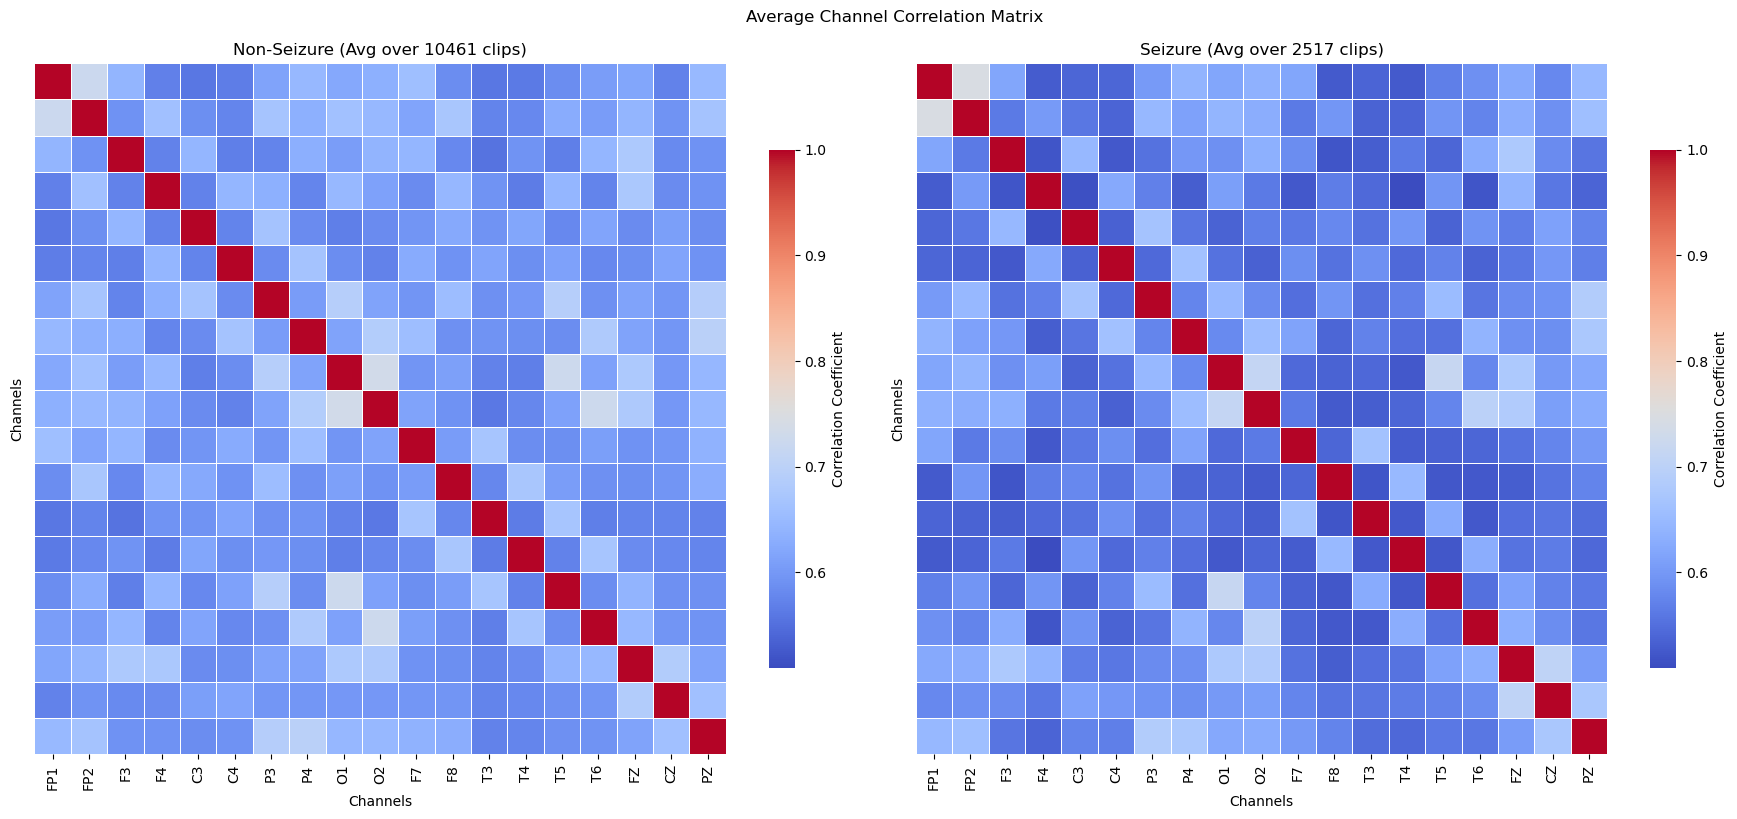

In [10]:
# Store correlation matrices for each class
corr_matrices_seizure = []
corr_matrices_non_seizure = []
limit = 10e4 # default limit: 100k clips

# Iterate through dataset to calculate correlation matrix for each clip
processed_count = 0
for x, y in dataset_tr:
    if processed_count >= limit:
        print(f"Reached calculation limit of {limit} clips for correlation.")
        break
    processed_count += 1

    if isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[0] > 1 and x.shape[1] > 1:
        # Create a DataFrame for easy correlation calculation
        clip_df = pd.DataFrame(x, columns=channel_names[:x.shape[1]])
        # Calculate pairwise correlation between channels
        corr_matrix = clip_df.corr()
        # Store based on label (only if calculation is successful)
        if not corr_matrix.isnull().values.any(): # Check for NaNs
            if y == 1:
                corr_matrices_seizure.append(corr_matrix.values) # Store as numpy array
            else:
                corr_matrices_non_seizure.append(corr_matrix.values) # Store as numpy array

# Calculate the average correlation matrix for each class
avg_corr_seizure = None
avg_corr_non_seizure = None
num_channels_corr = 0

if corr_matrices_seizure:
    avg_corr_seizure = np.mean(corr_matrices_seizure, axis=0)
    num_channels_corr = avg_corr_seizure.shape[0]
if corr_matrices_non_seizure:
    avg_corr_non_seizure = np.mean(corr_matrices_non_seizure, axis=0)
    if num_channels_corr == 0: num_channels_corr = avg_corr_non_seizure.shape[0]

# --- Plotting Average Correlation Heatmaps ---
if avg_corr_non_seizure is not None or avg_corr_seizure is not None:
    # Determine common color scale range based on available data
    all_corrs = []
    if avg_corr_non_seizure is not None: all_corrs.append(avg_corr_non_seizure)
    if avg_corr_seizure is not None: all_corrs.append(avg_corr_seizure)
    if all_corrs:
      vmin = np.min([np.min(c[np.isfinite(c)]) for c in all_corrs if np.any(np.isfinite(c))])
      vmax = np.max([np.max(c[np.isfinite(c)]) for c in all_corrs if np.any(np.isfinite(c))])
      # Center around 0 if data spans positive and negative, otherwise use min/max
      if vmin < 0 and vmax > 0:
          abs_max = max(abs(vmin), abs(vmax))
          vmin, vmax = -abs_max, abs_max
    else:
        vmin, vmax = -1, 1 # Default if no data

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    fig.suptitle('Average Channel Correlation Matrix')

    plot_idx = 0
    # Plot Non-Seizure Heatmap
    if avg_corr_non_seizure is not None:
        ax = axes[plot_idx]
        sns.heatmap(
            avg_corr_non_seizure,
            ax=ax,
            cmap='coolwarm', # Diverging colormap centered around 0
            vmin=vmin, vmax=vmax, # Use common scale
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .7, "label": "Correlation Coefficient"},
            xticklabels=channel_names[:num_channels_corr],
            yticklabels=channel_names[:num_channels_corr]
        )
        ax.set_title(f'Non-Seizure (Avg over {len(corr_matrices_non_seizure)} clips)')
        ax.set_xlabel('Channels')
        ax.set_ylabel('Channels')
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)
        plot_idx += 1
    else:
        axes[plot_idx].set_title('Non-Seizure (No data)')
        axes[plot_idx].set_xticks([])
        axes[plot_idx].set_yticks([])
        plot_idx += 1


    # Plot Seizure Heatmap
    if avg_corr_seizure is not None:
        ax = axes[plot_idx]
        sns.heatmap(
            avg_corr_seizure,
            ax=ax,
            cmap='coolwarm',
            vmin=vmin, vmax=vmax, # Use common scale
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .7, "label": "Correlation Coefficient"},
            xticklabels=channel_names[:num_channels_corr],
            yticklabels=False # Share y-axis labels
        )
        ax.set_xlabel('Channels')
        ax.set_ylabel('Channels')
        ax.set_title(f'Seizure (Avg over {len(corr_matrices_seizure)} clips)')
        ax.tick_params(axis='x', rotation=90)
    else:
         axes[plot_idx].set_title('Seizure (No data)')
         axes[plot_idx].set_xticks([])
         axes[plot_idx].set_yticks([])


    plt.tight_layout() # Adjust layout to make room for suptitle
    plt.show()
else:
    print("No correlation data calculated to plot.")

To identify channel pairs whose correlation patterns differ significantly between seizure and non-seizure states, we can compute a **correlation difference matrix**. This matrix highlights the connections that change the most, potentially indicating relevance for distinguishing between the two classes.

The change in correlation, $c^{\text{change}}$, between any two channels $i$ and $j$ is calculated as the absolute difference between their average correlation coefficients in the seizure ($c_{ij}^{\text{seizure}}$) and non-seizure ($c_{ij}^{\text{non-seizure}}$) states:

$$
c_{ij}^{\text{change}} = |c_{ij}^{\text{seizure}} - c_{ij}^{\text{non-seizure}}|
$$

High values in this matrix correspond to channel pairs where the functional connectivity (as measured by linear correlation) undergoes the largest change between the two conditions.

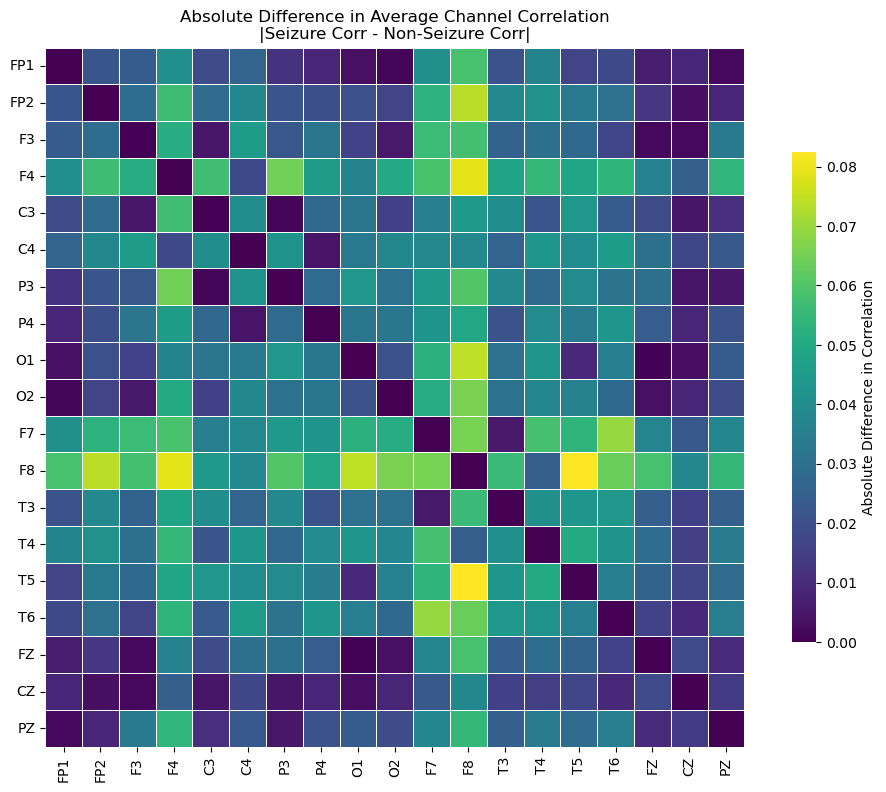

In [11]:
# --- Calculate the Absolute Difference Matrix ---
if avg_corr_seizure.shape == avg_corr_non_seizure.shape:
    # Calculate the element-wise absolute difference
    abs_diff_corr = np.abs(avg_corr_seizure - avg_corr_non_seizure)
    num_channels_corr = abs_diff_corr.shape[0]

    # --- Plotting the Absolute Difference Heatmap ---
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        abs_diff_corr,
        cmap='viridis', # Sequential colormap: higher value = greater difference
        vmin=0, # Difference magnitude starts from 0
        vmax=np.max(abs_diff_corr[np.isfinite(abs_diff_corr)]), # Max observed difference
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .7, "label": "Absolute Difference in Correlation"},
        xticklabels=channel_names[:num_channels_corr],
        yticklabels=channel_names[:num_channels_corr]
    )
    plt.title('Absolute Difference in Average Channel Correlation\n|Seizure Corr - Non-Seizure Corr|')
    plt.tick_params(axis='x', rotation=90)
    plt.tick_params(axis='y', rotation=0)
    plt.tight_layout(pad=1.0)
    plt.show()

else:
    print("Error: Average correlation matrices have different shapes.")

The absolute difference correlation matrix helps identify **pairs of channels** whose functional connectivity (measured by linear correlation) significantly changes between seizure and non-seizure states. By selecting the top $K$ pairs with the highest absolute difference values, we are essentially performing a feature selection strategy that prioritizes these **most altered pairwise interactions**.

In order to compute the **importance score** for individual channels based on this pairwise information, we use the sum of absolute differences across all other channels it is paired with. This score, $S_i$, for a channel $i$ reflects its total involvement in correlation changes:

$$
S_i = \sum_{j \neq i} |c_{ij}^{\text{seizure}} - c_{ij}^{\text{non-seizure}}| = \sum_{j \neq i} |c_{ij}^{\text{change}}|
$$

The top $K$ individual channels are then selected based on descending order of this score.

**Important Caveat**: This is a heuristic method. It ranks channels based on the aggregate change in their pairwise correlations. It doesn't guarantee that these channels, when used individually or with their raw signals/features, will be the optimal set for a machine learning model. Other feature selection methods might yield different results.

In [12]:
def select_top_k_channels_by_sum_diff(abs_diff_matrix, channel_names_list, k=10):
    """Selects top K individual channels based on sum of absolute differences."""

    if abs_diff_matrix is None or not isinstance(abs_diff_matrix, np.ndarray) or abs_diff_matrix.ndim != 2:
        print("Error: Invalid absolute difference matrix provided.")
        return None
    if abs_diff_matrix.shape[0] != abs_diff_matrix.shape[1]:
         print("Error: Matrix must be square.")
         return None
    if len(channel_names_list) != abs_diff_matrix.shape[0]:
         print("Error: Number of channel names does not match matrix dimension.")
         return None

    print(f"Selecting top {k} individual channels based on sum of correlation differences...")

    # Calculate the score for each channel by summing its row/column
    # Since the matrix is symmetric and diagonal is 0, summing rows is sufficient.
    channel_scores = np.sum(abs_diff_matrix, axis=1)

    # Get the indices that would sort the scores in descending order
    sorted_indices = np.argsort(channel_scores)[::-1] # [::-1] reverses to descending

    # Select the top K indices
    top_k_indices = sorted_indices[:k]

    # Store the results (channel name and score)
    top_channels = []
    for i in top_k_indices:
        top_channels.append({
            'channel_name': channel_names_list[i],
            'score': channel_scores[i]
            })

    # The list is already sorted by score due to using sorted_indices
    return top_channels

# --- Run the selection ---
K = 5 # Number of top individual channels to select
top_k_individual_channels = select_top_k_channels_by_sum_diff(abs_diff_corr, channel_names, k=K)

# --- Display the results ---
if top_k_individual_channels:
    print(f"\nTop {K} Individual Channels by Sum of Absolute Correlation Difference:")
    print("-" * 50)
    print(f"{'Rank':<5} {'Channel Name':<20} {'Score (Sum Abs Diff)':<20}")
    print("-" * 50)
    for i, item in enumerate(top_k_individual_channels):
        print(f"{i+1:<5} {item['channel_name']:<20} {item['score']:.4f}")
    print("-" * 50)

Selecting top 5 individual channels based on sum of correlation differences...

Top 5 Individual Channels by Sum of Absolute Correlation Difference:
--------------------------------------------------
Rank  Channel Name         Score (Sum Abs Diff)
--------------------------------------------------
1     F8                   1.0451
2     F4                   0.8780
3     F7                   0.8235
4     T4                   0.6691
5     T5                   0.6650
--------------------------------------------------


## Data splitting and (possible) feature selection

In [13]:
# ——— split training set into train & validation with pandas ———
print("⏳ Splitting into train/validation…")
split_start = time.time()
train_frac = 0.8
train_df   = clips_tr.sample(frac=train_frac)
val_df     = clips_tr.drop(train_df.index)
print(f"✔️ Split: {len(train_df)} train, {len(val_df)} val "
      f"(took {time.time()-split_start:.1f}s)")

# ——— rebuild training/validation datasets using the new split ———
print("⏳ Building EEGDataset objects…")
ds_start = time.time()
dataset_tr = EEGDataset(
    train_df,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)
print(f"✔️ Train dataset ready: {len(dataset_tr)} segments (took {time.time()-ds_start:.1f}s)")
dataset_val = EEGDataset(
    val_df,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)
print(f"✔️ Validation dataset ready: {len(dataset_val)} segments (took {time.time()-ds_start:.1f}s)")
dataset_te = EEGDataset(
    clips_te,
    signals_root=DATA_ROOT / "test",
    signal_transform=fft_filtering,
    prefetch=True,
    return_id=True,
)
print(f"✔️ Test dataset ready: {len(dataset_te)} segments (took {time.time()-ds_start:.1f}s)")

⏳ Splitting into train/validation…
✔️ Split: 10394 train, 2599 val (took 0.1s)
⏳ Building EEGDataset objects…
✔️ Train dataset ready: 10394 segments (took 192.8s)
✔️ Validation dataset ready: 2599 segments (took 200.4s)
✔️ Test dataset ready: 3614 segments (took 205.9s)


In [22]:
# ——— create data loaders ———
print("⏳ Creating DataLoaders…")
dl_start = time.time()
common_loader_kwargs = dict(
    batch_size=2048,
    num_workers=16,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=8,
)

# NOTE: shuffle=True for training, False for validation and test in order to
#       maintain the order of the data (important for evaluation)
train_loader = DataLoader(dataset_tr, shuffle=True,  **common_loader_kwargs)
val_loader   = DataLoader(dataset_val, shuffle=False, **common_loader_kwargs)
test_loader  = DataLoader(dataset_te, shuffle=False, **common_loader_kwargs)
print(f"✔️ DataLoaders created (took {time.time()-dl_start:.1f}s):\n"
      f"   • train: {len(train_loader)} batches\n"
      f"   • val:   {len(val_loader)} batches\n"
      f"   • test:  {len(test_loader)} batches")

⏳ Creating DataLoaders…
✔️ DataLoaders created (took 0.0s):
   • train: 6 batches
   • val:   2 batches
   • test:  2 batches


## Define training and test loop

In [23]:
def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    save_path: Path,
    num_epochs: int = 1000,
    patience: int = 100,
    overwrite: bool = False,
):
    """
    Trains `model` with early stopping on val loss.  
    If overwrite=True, deletes any existing checkpoint;  
    if a checkpoint exists (and overwrite=False), loads it and skips training.
    Returns (train_losses, val_losses).
    """
    # handle overwrite / existing
    if overwrite and save_path.exists():
        save_path.unlink()
        print(f"[OVERWRITE] removed {save_path}")
    if save_path.exists():
        model.load_state_dict(torch.load(save_path, map_location=device))
        print(f"Loaded existing checkpoint, skipping training.")
        return [], []

    best_val = float("inf")
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    pbar = tqdm(range(1, num_epochs + 1), desc="Epochs", dynamic_ncols=True)
    for epoch in pbar:
        # ——— TRAIN ———
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float().unsqueeze(1)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            run_loss += loss.item()

        avg_train = run_loss / len(train_loader)
        train_losses.append(avg_train)

        # ——— VALIDATE ———
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device).float(), yb.to(device).float().unsqueeze(1)
                val_loss += criterion(model(xb), yb).item()
        avg_val = val_loss / len(val_loader)
        val_losses.append(avg_val)

        # ——— CHECKPOINT & EARLY STOP ———
        saved = False
        if avg_val < best_val:
            best_val = avg_val
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            saved = True
        else:
            epochs_no_improve += 1

        # update progress bar
        pbar.set_postfix({
            "train": f"{avg_train:.4f}",
            "val":   f"{avg_val:.4f}",
            "best":  f"{best_val:.4f}",
            "saved": "✓" if saved else "-",
            "gpu":   f"{torch.cuda.memory_allocated(device)/1e6:.1f}MB"
        })

        if epochs_no_improve >= patience:
            pbar.write(f"Stopping early: no improvement in {patience} epochs.")
            break

    print("Training done.")
    return train_losses, val_losses


def evaluate_model(
    model: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    save_path: Path,
    submission_path: Path,
    threshold: float = 0.5,
):
    """
    Loads best checkpoint at save_path, runs `model` on test_loader,
    writes a CSV at submission_path with columns ['id','label'].
    """
    # load & eval
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device).eval()

    all_ids, all_preds = [], []
    with torch.no_grad():
        for xb, xids in test_loader:
            xb = xb.to(device).float()
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().squeeze()
            preds = (probs > threshold).int().tolist()

            all_preds.extend(preds)
            # handle tensor vs list of ids
            if isinstance(xids, list):
                all_ids.extend(xids)
            else:
                all_ids.extend(xids.cpu().tolist())

    sub = pd.DataFrame({"id": all_ids, "label": all_preds})
    sub = sub.sort_values("id")
    sub.to_csv(submission_path, index=False)
    print(f"Saved submission → {submission_path}")


## Traditional approaches

### 1. No extra features, LSTM classifier

In [24]:
from layers.lstm import LSTM

# Create model and fit it
model = LSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.3)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)   # splits batches across all GPUs
model = model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

ImportError: cannot import name 'LSTM' from 'layers.lstm' (/home/ldibello/NeuroGraphNet/layers/lstm.py)

#### LSTM classifier - training w/ early stopping 

In [25]:
LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=LSTM_SAVE_PATH,
        num_epochs=1000,
        patience=100,
        overwrite=True
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate model on test set and generate submission file
evaluate_model(
    model, test_loader, device,
    save_path=LSTM_SAVE_PATH,
    submission_path=LSTM_SUBMISSION_PATH,
    threshold=0.5
)

[OVERWRITE] removed .checkpoints/lstm_best_model.pt


Epochs:   1%|          | 12/1000 [00:12<17:35,  1.07s/it, train=0.2125, val=0.2935, best=0.2642, saved=-, gpu=94.2MB] 


KeyboardInterrupt: 

[OVERWRITE ENABLED] Removed `.checkpoints/lstm_best_model.pt`.


Training: 100%|██████████| 1000/1000 [11:56<00:00,  1.39it/s, train_loss=0.2158, val_loss=0.2765, best_val=0.2617, gpu_mem=41.4 MB, saved=-]   

Training completed.


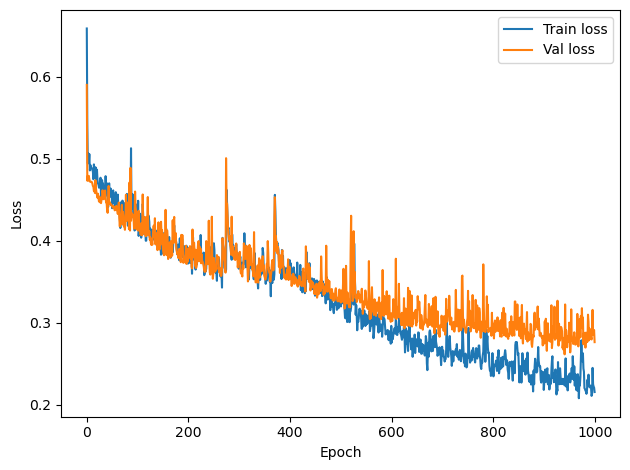

In [ ]:
save_path = CHECKPOINT_ROOT / "lstm_best_model.pt"
patience = 100 # no. runs without improvement before stopping

# NOTE: set to True to remove old model and retrain from scratch. 
# Keep false to load existing model.
OVERWRITE = True
if OVERWRITE:
    # remove old model
    if os.path.exists(save_path):
        os.remove(save_path)
        print(f"[OVERWRITE ENABLED] Removed `{save_path}`.")
    else:
        print(f"[OVERWRITE ENABLED] Model `{save_path}` not found, nothing to remove.")

if os.path.exists(save_path):
    # load & skip training
    model.load_state_dict(torch.load(save_path, map_location=device))
    print(f"Found `{save_path}`, loaded weights and skipped training.")
else:
    best_val_loss = float("inf")
    epochs_since_improve = 0

    train_losses = []
    val_losses   = []

    num_epochs = 1000
    pbar = tqdm(range(num_epochs), desc="Training", dynamic_ncols=True)

    for epoch in pbar:
        # --- TRAINING PASS ---
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().unsqueeze(1).to(device)

            logits = model(x_batch)
            loss   = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train = running_loss / len(train_loader)
        train_losses.append(avg_train)

        # --- VALIDATION PASS ---
        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.float().to(device)
                y_val = y_val.float().unsqueeze(1).to(device)
                val_running += criterion(model(x_val), y_val).item()

        avg_val = val_running / len(val_loader)
        val_losses.append(avg_val)

        # early‑stop & save best
        saved = False
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            epochs_since_improve = 0
            torch.save(model.state_dict(), save_path)
            saved = True
        else:
            epochs_since_improve += 1

        # update bar
        pbar.set_postfix({
            "train_loss": f"{avg_train:.4f}",
            "val_loss":   f"{avg_val:.4f}",
            "best_val":   f"{best_val_loss:.4f}",
            "gpu_mem":    f"{torch.cuda.memory_allocated(device)/1e6:.1f} MB",
            "saved":      "saved" if saved else "-",
        })

        if epochs_since_improve >= patience:
            pbar.write(f"No improvement in {patience} epochs. Stopping early.")
            break

    print("Training completed.")

    # --- PLOT your losses ---
    plt.figure()
    plt.plot(train_losses,     label="Train loss")
    plt.plot(val_losses,       label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### LSTM Classifier - Test

In [20]:
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

all_ids = []
all_predictions = []

with torch.no_grad():
    for x_batch, x_ids in test_loader:
        x_batch = x_batch.float().to(device)
        logits  = model(x_batch)

        # binary
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int().cpu().squeeze()

        all_predictions.extend(preds.tolist())

        # <-- drop the .tolist() if x_ids is already a list
        if isinstance(x_ids, list):
            all_ids.extend(x_ids)
        else:
            all_ids.extend(x_ids.cpu().tolist())

submission_df = (
    pd.DataFrame({"id": all_ids, "label": all_predictions})
      .sort_values("id")
)
submission_df.to_csv(SUBMISSION_ROOT/"submission_lstm.csv", index=False)
print("Saved submission_lstm.csv")


Saved submission_lstm.csv


#### RNN w/ Early stopping

In [ ]:
from layers.eegcnn import EEGCNN

# Create model and fit it
model = EEGCNN(input_channels=19, num_classes=1, dropout=0.3)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)   # splits batches across all GPUs
model = model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)